In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F
import gin
from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
import gin
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.config.config import Config
from sparse_causal_model_learner_rl.trainable.decoder import IdentityDecoder
from keychest.keychestenv import obss_to_rgb

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/common.gin', '../keychest/config/5x5.gin'])

['common', '5x5']

In [3]:
learner = CausalModelLearnerRL(Config())
env = learner.env
h, w, c = env.engine._observation.shape

Make environment KeyChest-v0 None {}


In [4]:
def get_xy(steps=1000):
    """Get the dataset."""
    gin.bind_parameter('Config.feature_shape', None)
    gin.bind_parameter('KeyChestEnvironment.flatten_observation', True)
    gin.bind_parameter('Config.env_steps', steps)
    gin.bind_parameter('Config.decoder', None)
    gin.bind_parameter('Config.model', None)
    gin.bind_parameter('Config.reconstructor', None)
    gin.bind_parameter('Config.value_predictor', None)
    learner = CausalModelLearnerRL(Config())
    learner.collect_steps(do_tqdm=True)
    obs_x = learner._context.get('obs_x').cpu().numpy()
    obs_y = learner._context.get('obs_y').cpu().numpy()
    act_x = learner._context.get('action_x').cpu().numpy()

    X = np.concatenate((obs_x, act_x), axis=1)
    y = obs_y
    return X, y

In [12]:
X, _ = get_xy(200)
X = X[:, :-4]
X = X.reshape((-1, h, w, c))
X_rgb = obss_to_rgb(X, env.engine)

Make environment KeyChest-v0 None {}



3.0


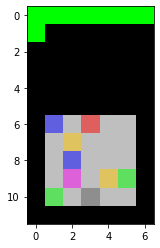

In [20]:
plt.imshow(X_rgb[0])

In [62]:
def dict_to_arr(d):
    """Dictionary to a list with keys sorted."""
    return np.array([d[k] for k in sorted(d.keys())], dtype=np.float32)

In [63]:
def obs_features_handcoded(obs, env):
    """Get features for an observation."""
    engine = env.engine
    
    def get_map(key):
        idx = engine.OBJECTS.index(key)
        return obs[:, :, idx]
    
    result = {}
    result['health'] = np.sum(get_map('health'))
    result['keys'] = np.sum(get_map('keys_collected'))
    lamp_on = np.sum(get_map('lamp_on'))
    lamp_off = np.sum(get_map('lamp_off'))
    result['lamp_status'] = 1 if lamp_on else (0 if lamp_off else -1)
    
    n_keys = gin.query_parameter('KeyChestEnvironmentRandom.n_keys')
    n_chests = gin.query_parameter('KeyChestEnvironmentRandom.n_chests')
    n_food = gin.query_parameter('KeyChestEnvironmentRandom.n_food')
    
    objects_to_out = ['key', 'chest', 'food', 'button', 'player', 'lamp_on', 'lamp_off']
    objects_cnt = {'key': n_keys, 'chest': n_chests, 'food': n_food}
    
    def register(key, x, y, idx=None):
        if x is None:
            x = -1
        if y is None:
            y = -1
        name_prefix = key + "_"
        if idx is not None:
            name_prefix = "%s%02d_" % (name_prefix, idx)
        
        result[name_prefix + "x"] = x
        result[name_prefix + "y"] = y
    
    def arr_get_val(arr, idx):
        if idx < len(arr):
            x, y = arr[idx]
        else:
            x, y = -1, -1
        return x, y
    
    for key in objects_to_out:
        m = get_map(key)
        where = sorted(list(zip(*np.where(m))))
#         print(key, where)
        assert len(where) <= 1 or key in objects_cnt
        
        if key in objects_cnt:
            for i in range(objects_cnt[key]):
                x, y = arr_get_val(where, i)
                register(key, x, y, i)
        else:
            x, y = arr_get_val(where, 0)
            register(key, x, y, None)
    
    return result

In [68]:
Fdict = [obs_features_handcoded(x, env) for x in X]
F = np.array([dict_to_arr(f) for f in Fdict])

In [64]:
f = obs_features_handcoded(X[0], env)

In [65]:
dict_to_arr(f)

array([ 9.,  2.,  7.,  2.,  9.,  4.,  9.,  5., 10.,  1.,  8.,  6.,  1.,
        8.,  2.,  0., 10.,  3., -1., -1.,  0.,  6.,  3.], dtype=float32)

In [27]:
X_rgb[0].shape

(12, 7, 3)

In [72]:
F.shape

(184, 23)

{'health': 3.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 7, 'key_00_y': 3, 'key_01_x': 8, 'key_01_y': 5, 'chest_00_x': 6, 'chest_00_y': 2, 'chest_01_x': 7, 'chest_01_y': 5, 'food_00_x': 6, 'food_00_y': 3, 'food_01_x': 10, 'food_01_y': 4, 'button_x': 6, 'button_y': 4, 'player_x': 7, 'player_y': 5, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 1}


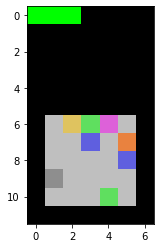

{'health': 6.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 1, 'key_01_x': 10, 'key_01_y': 1, 'chest_00_x': 6, 'chest_00_y': 4, 'chest_01_x': 8, 'chest_01_y': 5, 'food_00_x': 9, 'food_00_y': 3, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 10, 'button_y': 5, 'player_x': 7, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 8, 'lamp_off_y': 2}


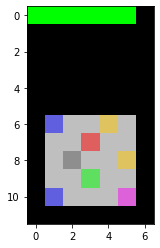

{'health': 5.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 1, 'key_01_x': 8, 'key_01_y': 2, 'chest_00_x': 7, 'chest_00_y': 2, 'chest_01_x': 9, 'chest_01_y': 4, 'food_00_x': 9, 'food_00_y': 5, 'food_01_x': 10, 'food_01_y': 1, 'button_x': 9, 'button_y': 2, 'player_x': 7, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


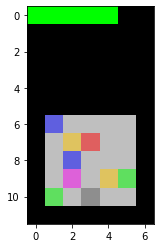

{'health': 7.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 7, 'key_00_y': 2, 'key_01_x': 7, 'key_01_y': 3, 'chest_00_x': 7, 'chest_00_y': 4, 'chest_01_x': 9, 'chest_01_y': 4, 'food_00_x': 10, 'food_00_y': 5, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 6, 'button_y': 3, 'player_x': 10, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 8, 'lamp_off_y': 2}


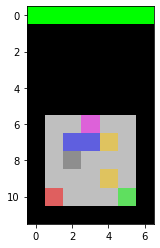

{'health': 1.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 1, 'key_01_x': 8, 'key_01_y': 2, 'chest_00_x': 7, 'chest_00_y': 2, 'chest_01_x': 9, 'chest_01_y': 4, 'food_00_x': 9, 'food_00_y': 5, 'food_01_x': 10, 'food_01_y': 1, 'button_x': 9, 'button_y': 2, 'player_x': 6, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


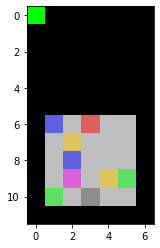

{'health': 1.0, 'keys': 1.0, 'lamp_status': 1, 'key_00_x': 9, 'key_00_y': 1, 'key_01_x': -1, 'key_01_y': -1, 'chest_00_x': 8, 'chest_00_y': 4, 'chest_01_x': 10, 'chest_01_y': 5, 'food_00_x': 9, 'food_00_y': 4, 'food_01_x': 10, 'food_01_y': 1, 'button_x': 6, 'button_y': 3, 'player_x': 7, 'player_y': 3, 'lamp_on_x': 6, 'lamp_on_y': 2, 'lamp_off_x': -1, 'lamp_off_y': -1}


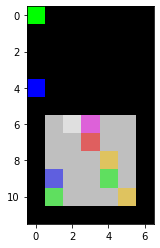

{'health': 3.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 9, 'key_00_y': 2, 'key_01_x': 10, 'key_01_y': 5, 'chest_00_x': 7, 'chest_00_y': 5, 'chest_01_x': 9, 'chest_01_y': 1, 'food_00_x': 8, 'food_00_y': 5, 'food_01_x': 10, 'food_01_y': 2, 'button_x': 7, 'button_y': 3, 'player_x': 7, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 7, 'lamp_off_y': 2}


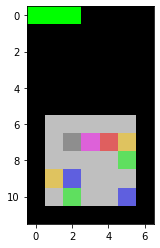

{'health': 1.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 8, 'key_00_y': 1, 'key_01_x': 10, 'key_01_y': 5, 'chest_00_x': 6, 'chest_00_y': 1, 'chest_01_x': 9, 'chest_01_y': 3, 'food_00_x': 8, 'food_00_y': 4, 'food_01_x': 8, 'food_01_y': 5, 'button_x': 6, 'button_y': 2, 'player_x': 10, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 6, 'lamp_off_y': 5}


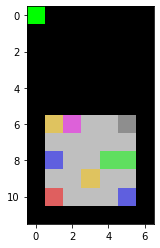

{'health': 5.0, 'keys': 1.0, 'lamp_status': 0, 'key_00_x': 10, 'key_00_y': 2, 'key_01_x': -1, 'key_01_y': -1, 'chest_00_x': 6, 'chest_00_y': 1, 'chest_01_x': 8, 'chest_01_y': 1, 'food_00_x': 10, 'food_00_y': 1, 'food_01_x': 10, 'food_01_y': 3, 'button_x': 8, 'button_y': 5, 'player_x': 6, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 6, 'lamp_off_y': 5}


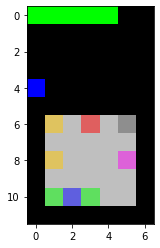

{'health': 6.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 1, 'key_01_x': 8, 'key_01_y': 2, 'chest_00_x': 7, 'chest_00_y': 2, 'chest_01_x': 9, 'chest_01_y': 4, 'food_00_x': 9, 'food_00_y': 5, 'food_01_x': 10, 'food_01_y': 1, 'button_x': 9, 'button_y': 2, 'player_x': 7, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


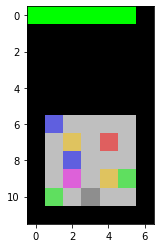

In [75]:
for i in range(10):
    idx = np.random.choice(len(X))
#     idx = i
    print(Fdict[idx])
    plt.imshow(X_rgb[idx])
    plt.show()

In [78]:
F

array([[ 9.,  2.,  7., ...,  0.,  6.,  3.],
       [ 9.,  2.,  7., ...,  0.,  7.,  3.],
       [ 9.,  2.,  7., ...,  0.,  7.,  4.],
       ...,
       [10.,  5.,  8., ...,  1.,  9.,  5.],
       [10.,  5.,  8., ...,  1.,  9.,  5.],
       [10.,  5.,  8., ...,  1., 10.,  5.]], dtype=float32)